# RomyEvents - Manual Eventplots

Creates automatic event plots based on catalog 

In [7]:
import os
import gc
import obspy as obs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import andbro__fft
from pprint import pprint
from functions.add_distances_and_backazimuth import __add_distances_and_backazimuth
from functions.querrySeismoData import __querrySeismoData
from functions.__makeplotStreamSpectra2 import __makeplotStreamSpectra2


### Configurations

In [8]:
config = {}

# set start event time period (in UTC)
config['tbeg'] = obs.UTCDateTime("2025-05-13 22:50")  

# duration of event in seconds
config['duration'] = 3000#3600*2

# ROMY coordinates
config['ROMY_lon'] = 11.275501
config['ROMY_lat'] = 48.162941

# frequency range for bandpass filter
config['fmin'] = 0.01 # in Hz
config['fmax'] = 0.1 # in Hz

# path for figures to store
config['outpath_figs'] = "C:/Bachelorarbeit/figures/"

# path for output data
config['outpath_data'] = "C:/Bachelorarbeit/data/waveforms/"

# path to data archive (only required if data should be requested from archive instead of online)
# config['path_to_archive'] = "/home/andbro/freenas/"

# specify seed codes of stations that should be used for the analysis
config['seeds'] = ["BW.ROMY.10.BJZ", "BW.ROMY..BJU", "BW.ROMY..BJV", "BW.ROMY..BJW", # ringlaser ROMY
                   "BW.RLAS..BJZ", # ringlaser G
                   "GR.FUR..BHZ", "GR.FUR..BHN", "GR.FUR..BHE", # seismometer ROMY
                   "GR.WET..BHZ", "GR.WET..BHN", "GR.WET..BHE", # seismometer G
                  ]

# path to catalogs
config['path_to_catalog'] = "C:/Bachelorarbeit/data/catalogs/"

# catalog file
config['catalog'] = "ROMY_global_catalog_20240501_20241224.pkl"

# set if existing files should be skipped
config['skip_existing'] = True

# set if figures should be saved
config['save_figures'] = True

# set if waveform data should be stored
config['store_waveforms'] = True



In [9]:
# set interactive status plot
%matplotlib tk

# RUN LOOP

Loop over events in catalog and request data for each event. Store data or event plots if
- skip existing files
- save figures
- store waveforms

is set in configurations, respectively.



In [10]:
# configuration adjustments for plots
config['title'] = f"{config['tbeg']} UTC"

# set start time as UTCDateTime object
config['tbeg'] = obs.UTCDateTime(str(config['tbeg']))

# same endtime
config['tend'] = config['tbeg'] + config['duration']

# initialize empty stream
st0 = obs.Stream()

errors = []

# load data
for seed in config['seeds']:
    try:
        # request data for FUR
        if "FUR" in seed:
            stx, invx = __querrySeismoData( seed_id=seed,
                                            starttime=config['tbeg'],
                                            endtime=config['tend'],
                                            repository='online',
                                            path=None,
                                            restitute=True,
                                            detail=None,
                                            fill_value=None,
                                        )
            if len(stx) == 0:
                print(f" -> data missing for {seed}")

            st0 += stx
            
        # request data for WET
        elif "WET" in seed:
            stx, invx = __querrySeismoData( seed_id=seed,
                                            starttime=config['tbeg'],
                                            endtime=config['tend'],
                                            repository='online',
                                            path=None,
                                            restitute=True,
                                            detail=None,
                                            fill_value=None,
                                        )
            if len(stx) == 0:
                print(f" -> data missing for {seed}")

            st0 += stx
        
        # request ADR data from archive
        elif "ROMY.22" in seed:
            stx, invx = __querrySeismoData( seed_id=seed,
                                            starttime=config['tbeg'],
                                            endtime=config['tend'],
                                            repository='archive',
                                            path=config['path_to_archive']+"temp_archive/",
                                            restitute=True,
                                            detail=None,
                                            fill_value=None,
                                        )

            if len(stx) == 0:
                print(f" -> data missing for {seed}")

            st0 += stx
        
        # request ringlaser data from george
        elif "ROMY" in seed:
            stx, invx = __querrySeismoData( seed_id=seed,
                                            starttime=config['tbeg'],
                                            endtime=config['tend'],
                                            repository='george',
                                            path=None,
                                            restitute=True,
                                        detail=None,
                                        fill_value=None,
                                    )
            if len(stx) == 0:
                print(f" -> data missing for {seed}")

            st0 += stx

        elif "RLAS" in seed:
            stx, invx = __querrySeismoData( seed_id=seed,
                                            starttime=config['tbeg'],
                                            endtime=config['tend'],
                                            repository='george',
                                            path=None,
                                            restitute=True, 
                                            detail=None,
                                            fill_value=None,
                                        )
            if len(stx) == 0:
                print(f" -> data missing for {seed}")

            st0 += stx

        else:
            print(f" -> {seed} not found")
                                        
    except Exception as e:
        print(e)
        print(f" -> failed to request {seed} for event ")
        errors.append(f" -> failed to request {seed} for event")
        continue

# stort stream by channel
st0 = st0.sort()

# check if any data is masked
for tr in st0:
    if isinstance(tr.data, np.ma.MaskedArray):
        print(f" -> {tr.stats.channel} has masked data. Filled with zeros.")
        tr.data = tr.data.filled(fill_value=0)

# processing data stream
print(" -> processing data stream ...")
st1 = st0.copy();
st1 = st1.detrend("linear");
st1 = st1.taper(0.1);
st1 = st1.filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=4, zerophase=True);

# trim data stream
st1 = st1.trim(config['tbeg'], config['tend']);
st0 = st0.trim(config['tbeg'], config['tend']);

# store waveform data
if config['store_waveforms']:

    # define filename
    filename = f"{str(config['tbeg']).split('.')[0].replace('-','').replace(':','').replace(' ','_')}"

    # check if subdirectory exists
    if not os.path.isdir(config['outpath_data']):
        print("created: ", config['outpath_data'])
        os.makedirs(config['outpath_data'])

    # store waveform data
    try:
        st0.write(config['outpath_data']+filename+".mseed");
        print(f" -> stored at: {config['outpath_data']+filename}.mseed")
    except Exception as e:
        print(f" -> error storing waveform: {e}")
        errors.append(f" -> error storing waveform: {e}")

# saving figures
if config['save_figures']:

    # check if subdirectory exists
    if not os.path.isdir(config['outpath_figs']+"raw/"):
        print("created: ", config['outpath_figs']+"raw/")
        os.makedirs(config['outpath_figs']+"raw/")
  

    # plotting figure
    fig1 = st0.plot(equal_scale=False, show=False);

    # store figure
    fig1.savefig(config['outpath_figs']+"raw/"+f"{filename}_raw.png", 
                    dpi=150, bbox_inches='tight', pad_inches=0.05)

    # check if subdirectory exists  
    if not os.path.isdir(config['outpath_figs']+"filtered/"):
        print("created: ", config['outpath_figs']+"filtered/")
        os.makedirs(config['outpath_figs']+"filtered/")

    # plotting figure
    fig2 = st1.plot(equal_scale=False, show=False);

    # store figure
    fig2.savefig(config['outpath_figs']+"filtered/"+f"{filename}_filtered.png", 
                    dpi=150, bbox_inches='tight', pad_inches=0.05)

    del fig1, fig2
    gc.collect()

pprint(errors)

'URLError' object has no attribute 'splitlines'
 -> failed to request BW.ROMY.10.BJZ for event 
'URLError' object has no attribute 'splitlines'
 -> failed to request BW.ROMY..BJU for event 
'URLError' object has no attribute 'splitlines'
 -> failed to request BW.ROMY..BJV for event 
'URLError' object has no attribute 'splitlines'
 -> failed to request BW.ROMY..BJW for event 
'URLError' object has no attribute 'splitlines'
 -> failed to request BW.RLAS..BJZ for event 
 -> processing data stream ...


C:\Users\bened\anaconda3\envs\ampratio\lib\site-packages\obspy\io\mseed\core.py:773: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


 -> stored at: C:/Bachelorarbeit/data/waveforms/20250513T225000.mseed
[' -> failed to request BW.ROMY.10.BJZ for event',
 ' -> failed to request BW.ROMY..BJU for event',
 ' -> failed to request BW.ROMY..BJV for event',
 ' -> failed to request BW.ROMY..BJW for event',
 ' -> failed to request BW.RLAS..BJZ for event']


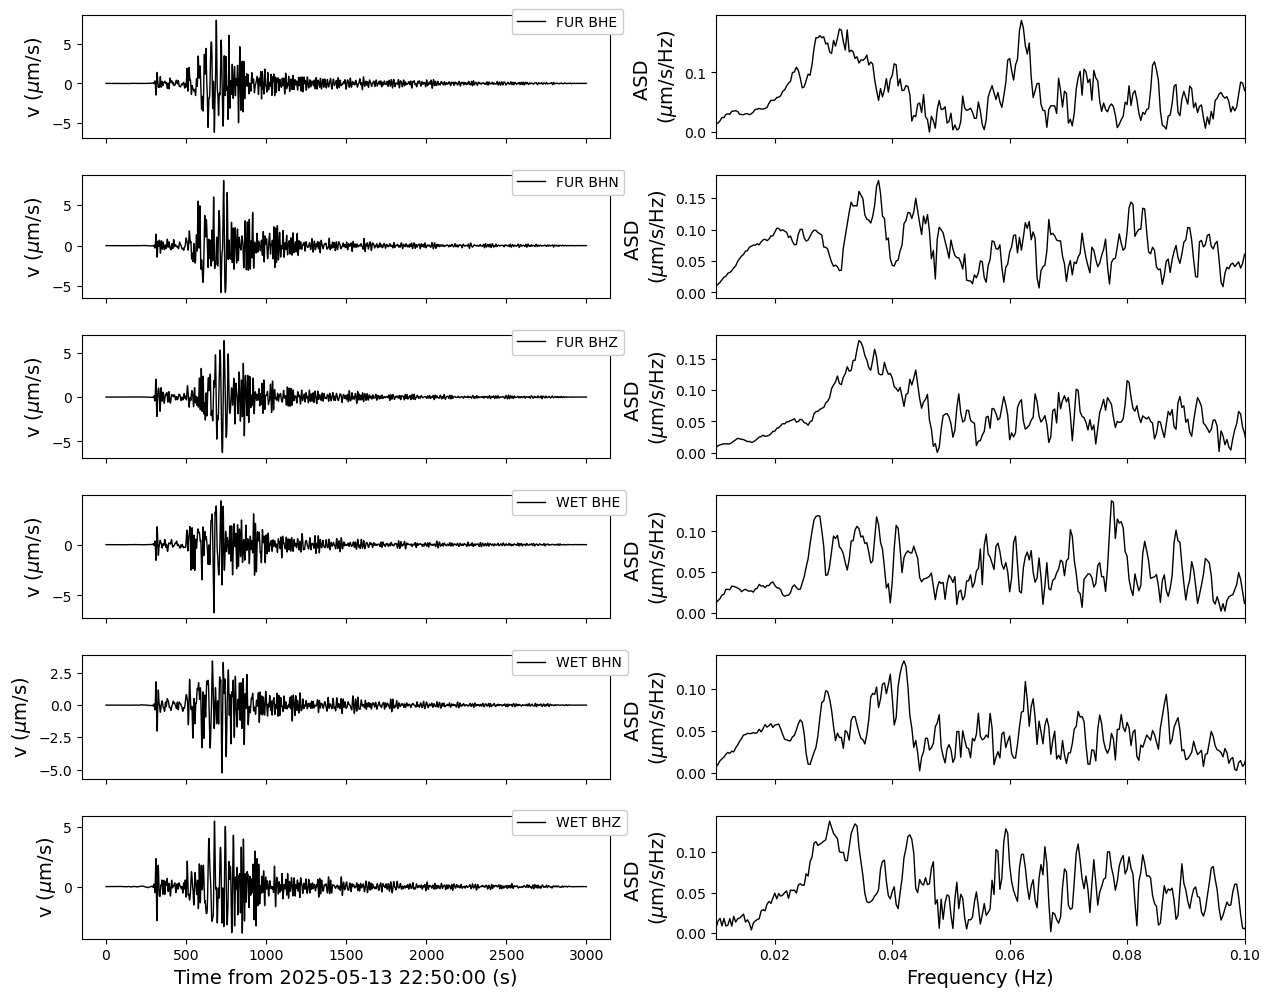

In [11]:
# make plot of waveforms and spectra
__makeplotStreamSpectra2(st1, config)